In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow import keras as k
import random
from tqdm import tqdm
import shutil
import datetime, os
import math

cwd = os.getcwd()
primary_dir = os.fsencode(cwd)


# shutil.rmtree("./logs_two_phase")
# logs_base_dir = "./logs_two_phase"
# os.makedirs(logs_base_dir, exist_ok=True)

# %load_ext tensorboard
# %tensorboard --logdir {logs_base_dir}

# tensorboard_callback = k.callbacks.TensorBoard(log_dir=logs_base_dir)
# writer = tf.summary.create_file_writer("./logs_two_phase")

In [2]:
binary_dict = {0: 'No triangle', 1 : 'Bias triangle'}


In [3]:
def block_splitting(image,return_block_data=False):  
    #image = np.squeeze(image)
    n = np.shape(image)[0]
    n_over_2 = math.floor(n/2.0)
    n_over_4 = math.floor(n/4.0)
    n_3_over_4 = math.floor(3*n/4.0)

    #Split into blocks based:
    block_1=image[0:n_over_2, 0:n_over_2]
    block_2=image[0:n_over_2,n_over_2:n]
    block_3=image[n_over_2:n,0:n_over_2]
    block_4=image[n_over_2:n,n_over_2:n]
    block_5=image[n_over_4:n_3_over_4,n_over_4:n_3_over_4]
    block_6=image[n_over_4:n_3_over_4,0:n_over_2]
    block_7=image[n_over_4:n_3_over_4,n_over_2:n]
    block_8=image[0:n_over_2,n_over_4:n_3_over_4]
    block_9=image[n_over_2:n,n_over_4:n_3_over_4]
    #Concatenate data into single 18-feature array:
    means=np.array([np.mean(block_1),np.mean(block_2),np.mean(block_3),np.mean(block_4),np.mean(block_5),np.mean(block_6),
           np.mean(block_7), np.mean(block_8),np.mean(block_9)])
    stds=np.array([np.std(block_1),np.std(block_2),np.std(block_3),np.std(block_4),np.std(block_5),np.std(block_6),
           np.std(block_7), np.std(block_8),np.std(block_9)])
    statistics=np.concatenate((means,stds))
    
    if return_block_data==True:
        return means,stds,statistics, [block_1, block_2, block_3, block_4, block_5, block_6, block_7, block_8, block_9]
        
    else:
        return statistics
    
def normalise(image):
    normalised_image=tf.image.per_image_standardization(image)
    return normalised_image

In [4]:
def create_cnn_model(pixel_size=32,dense_layers = [32*2,32,18,9],drop_out=0.4,l2=0.0001):
    
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(pixel_size, (3, 3), activation='relu', input_shape=(pixel_size, pixel_size, 1), padding="SAME"))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Conv2D(pixel_size*2, (3, 3), activation='relu', padding="SAME"))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Conv2D(pixel_size*2, (3, 3), activation='relu', padding="SAME"))
    
    cnn_model.add(layers.Flatten())
    for dense_layer in dense_layers:
        cnn_model.add(layers.Dense(dense_layer, activation='elu',kernel_regularizer=regularizers.l2(l2)))
        cnn_model.add(layers.Dropout(drop_out))

    return cnn_model

def create_statistical_model(input_size=18,dense_layers = [18,9],drop_out=0.4,l2=0.0001):

    statistical_model =  models.Sequential()
    statistical_model.add(layers.Dense(1, activation='elu',input_shape=(18,1)))
    statistical_model.add(layers.Flatten())
    
    for dense_layer in dense_layers:
        statistical_model.add(layers.Dense(dense_layer, activation='elu',kernel_regularizer=regularizers.l2(l2)))
        statistical_model.add(layers.Dropout(drop_out))
    
    return statistical_model


def create_final_model(modela,modelb,dense_layers = [9],drop_out=0.4,l2=0.0001):
    
    merged_output = layers.add([modela.output, modelb.output])   

    model_combined =  models.Sequential()
    
    for dense_layer in dense_layers:
        print('adding a dense layer')
        model_combined.add(layers.Dense(dense_layer, activation='elu',kernel_regularizer=regularizers.l2(l2)))
        model_combined.add(layers.Dropout(drop_out))
    
    model_combined.add(layers.Dense(1, activation='sigmoid'))
    
    final_model = models.Model([modela.input, modelb.input], model_combined(merged_output))

    return final_model

def compile_model(model):
    model.compile(optimizer='adam',
             loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

def plot_confusion(percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative):
    objects = ('true_positive','false_positive','true_negative','false_negative')
    y_pos = np.arange(len(objects))
    performance = [percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('count')
    plt.title('Confusion parameter')

    plt.show()
    
    return

def confusion_analysis(validate_images,validate_stats,validate_labels):
    true_positive = []
    false_positive = []
    true_negative = []
    false_negative = []
    for i in tqdm(range(len(validate_labels))):

        label = validate_labels[i][0]
        prediction = two_phase_model.predict([validate_images[i:i+1],validate_stats[i:i+1]])
        if (prediction > 0.5):
            prediction = 1
        else:
            prediction = 0
        if (prediction == label):
            if (label == 1):
                true_positive.append(validate_images[i:i+1])
                prnt = "True positive"
            else:
                true_negative.append(validate_images[i:i+1])
                prnt = "True negative"
        else:
            if (label == 1):
                false_negative.append(validate_images[i:i+1])
                prnt = "False negative"
            else:
                false_positive.append(validate_images[i:i+1])
                prnt = "False positive"
        if (i<5):
            print('------------------------------------------')
            print(prnt)
            print('Label = ', binary_dict[label]," = ", label)
            print('prediction = ', prediction)
            plt.clf()
            plt.imshow(validate_images[i][:,:,0])
            plt.show()

    n_true_positive = np.shape(true_positive)[0]
    n_false_positive = np.shape(false_positive)[0]
    n_true_negative = np.shape(true_negative)[0]
    n_false_negative = np.shape(false_negative)[0]

    total_test = n_true_positive + n_false_positive + n_true_negative + n_false_negative

    percent_true_positive = 100 * n_true_positive/total_test
    percent_false_positive = 100 *n_false_positive/total_test
    percent_true_negative = 100 *n_true_negative/total_test
    percent_false_negative = 100 *n_false_negative/total_test

    plot_confusion(percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative)

    return percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative


def min_max(feature_array): #used to find the min and max values of each feature (column) of the array
    data_array = np.zeros(shape=(2,18))
    for j in range(18):
        col = feature_array[:,j]
        data_array[0,j]= col.min(axis=0)
        data_array[1,j]= col.max(axis=0)
    return data_array

def normaliser(feature_array,min_max_array): #Normalises based on the eqaution (x-xmin) / (xmax-xmin)
    norm_feature_array=np.zeros(shape=(len(feature_array),18))
    feature_array_copy=feature_array.copy()
    for i in range(len(feature_array_copy)):
        for j in range(18):
            norm_feature_array[i,j]=((feature_array_copy[i,j]-min_max_array[0,j])/
                                     (min_max_array[1,j]-min_max_array[0,j]))
    return norm_feature_array

def train_model(model,images,labels,epochs,batch_size,val_split = 0.2):
    
    stats = []
    
    images = normalise(images) 
    
    for index,image in enumerate(images):
        stats.append(block_splitting(image))
    
    val_split = 0.2
    val_set = np.int(val_split*np.shape(labels)[0])
        
    #data_total = normalise(images) 
    data_total = images

    train_images = np.array(data_total[val_set:]).reshape(-1, 32, 32, 1)
    train_stats = np.array(stats[val_set:]).reshape(-1, 18, 1)
    train_labels = np.array(labels[val_set:]).reshape(-1, 1)
    validate_images = np.array(data_total[:val_set]).reshape(-1, 32, 32, 1)
    validate_stats = np.array(stats[:val_set]).reshape(-1, 18, 1)
    validate_labels = np.array(labels[:val_set]).reshape(-1, 1) 
    
    min_max_array=min_max(train_stats)
    train_norm_stats=normaliser(train_stats,min_max_array).reshape(-1, 18, 1)
    validate_norm_stats=normaliser(validate_stats,min_max_array).reshape(-1, 18, 1)

    
    history = model.fit([train_images,train_norm_stats],train_labels,shuffle=True, epochs=epochs, batch_size=batch_size, 
                        validation_data=([validate_images,validate_norm_stats],validate_labels)) #callbacks=[tensorboard_callback])
   
    percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative = confusion_analysis(validate_images,validate_stats,validate_labels)
    
    return model, history, percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative


def evaluate_model(model,history):
    plt.clf()
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.0, 1.1])
    plt.legend(loc='lower right')
    plt.show()
    
    return 

def normalise(x):
    x = tf.image.per_image_standardization(x)
    return x

In [5]:
cnn_model = create_cnn_model()
#cnn_model.summary()

statistical_model = create_statistical_model()
#statistical_model.summary()

#print(cnn_model.output)
#print(statistical_model.output)
#k.utils.plot_model(statistical_model)

two_phase_model = create_final_model(cnn_model,statistical_model)
two_phase_model.summary()
print(two_phase_model.input)

compile_model(two_phase_model)

adding a dense layer
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         conv2d_input[0][0]               
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   18496       max_pooling2d[0][0]              
_________________________________________________________________________

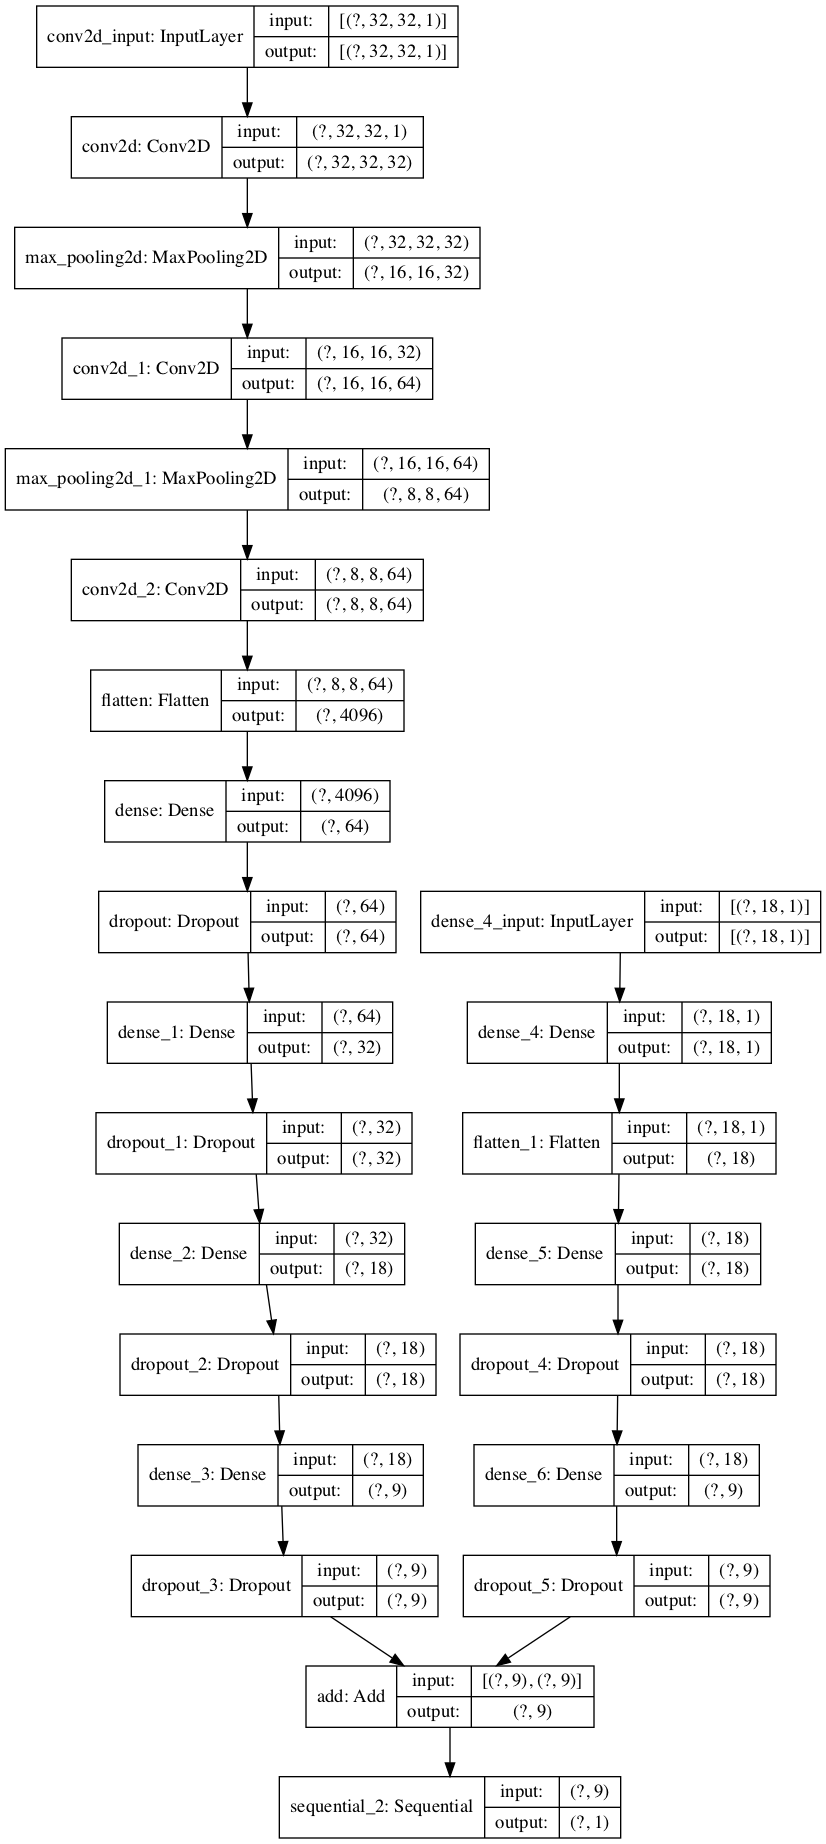

In [6]:
import graphviz
k.utils.plot_model(two_phase_model,show_shapes=True)

In [7]:
images = np.load('/Users/joshking/Documents/01Masters/Data/all_data_16_03_2020.npy')
labels = np.load('/Users/joshking/Documents/01Masters/Data/all_labels_16_03_2020.npy')

#/Users/joshking/Dropbox/Quantum/Triangles/normalised_data_matrices_train.npy
#/Users/joshking/Dropbox/Quantum/Triangles/normalised_data_labels_train.npy

In [8]:
import random
import numpy as np
def myfunction():
    return 0.9

z=np.arange(len(images))
random.shuffle(z)
print(z[:10])

images_copy=images.copy()
images_shuffle=images.copy()

labels_copy=labels.copy()
labels_shuffle=labels.copy()

for i in range(len(images)):
    images_shuffle[i]=images_copy[z[i]]
    labels_shuffle[i]=labels_copy[z[i]]   
print(images_shuffle.shape)

[11009 11994 12249 11172  7313 10341  2490 20810 12266  5444]
(23315, 32, 32)


adding a dense layer
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_3_input (InputLayer)     [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 32)   320         conv2d_3_input[0][0]             
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 64)   18496       max_pooling2d_2[0][0]            
_______________________________________________________________________

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
False positive
Label =  No triangle  =  0
prediction =  1


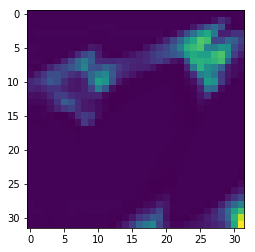

  0%|          | 1/4663 [00:00<27:03,  2.87it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


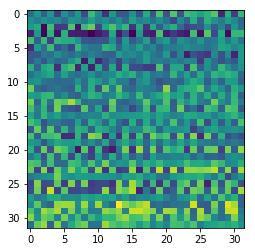

  0%|          | 2/4663 [00:00<22:59,  3.38it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


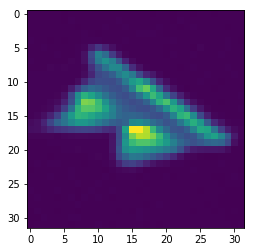

  0%|          | 3/4663 [00:00<19:40,  3.95it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


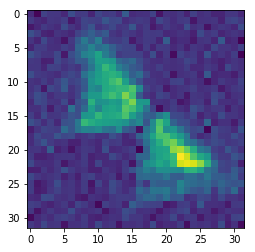

  0%|          | 4/4663 [00:00<17:24,  4.46it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


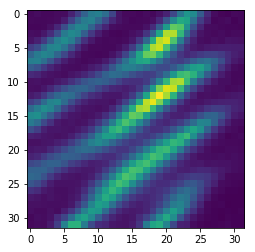

100%|██████████| 4663/4663 [03:02<00:00, 25.49it/s]


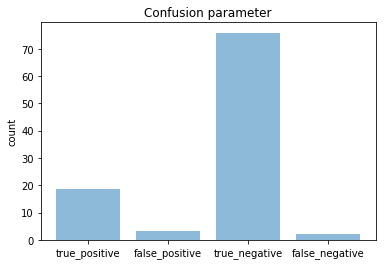

adding a dense layer
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_6_input (InputLayer)     [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   320         conv2d_6_input[0][0]             
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 16, 16, 64)   18496       max_pooling2d_4[0][0]            
_______________________________________________________________________

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


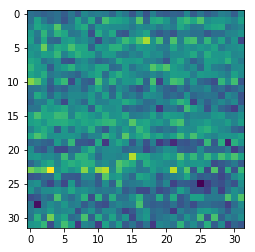

  0%|          | 1/4663 [00:00<22:37,  3.43it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


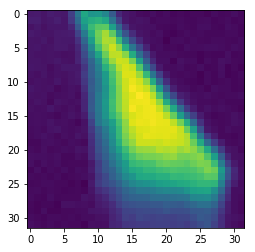

  0%|          | 2/4663 [00:00<19:23,  4.01it/s]

------------------------------------------
False positive
Label =  No triangle  =  0
prediction =  1


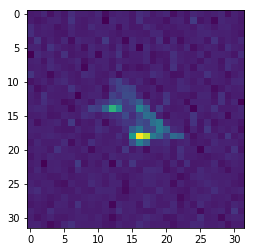

  0%|          | 3/4663 [00:00<17:03,  4.55it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


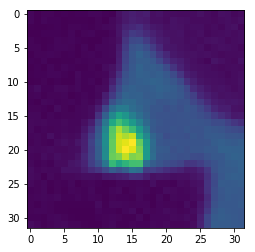

  0%|          | 4/4663 [00:00<15:36,  4.98it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


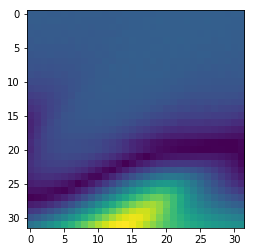

100%|██████████| 4663/4663 [03:20<00:00, 23.30it/s]  


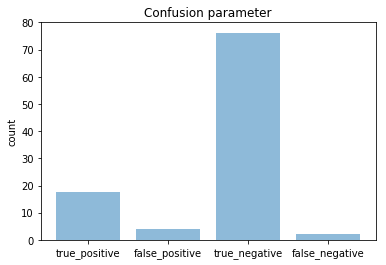

In [9]:
epochs = 10
batch_size = 100
perc_true_positive_tot = []
perc_false_positive_tot = []
perc_true_negative_tot = []
perc_false_negative_tot = []

for i in range(2):
    
    
    cnn_model = create_cnn_model()
    statistical_model = create_statistical_model()
    two_phase_model = create_final_model(cnn_model,statistical_model)
    two_phase_model.summary()
    compile_model(two_phase_model)

    z=np.arange(len(images))
    random.shuffle(z)
    print(z[:10])

    images_copy=images.copy()
    images_shuffle=images.copy()
    labels_copy=labels.copy()
    labels_shuffle=labels.copy()

    for i in range(len(images)):
        images_shuffle[i]=images_copy[z[i]]
        labels_shuffle[i]=labels_copy[z[i]]   
    
    two_phase_model, history, percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative= train_model(two_phase_model,images_shuffle,labels_shuffle,epochs,batch_size)
    perc_true_positive_tot.append(percent_true_positive)
    perc_false_positive_tot.append(percent_false_positive)
    perc_true_negative_tot.append(percent_true_negative)
    perc_false_negative_tot.append(percent_false_negative)

adding a dense layer
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_9_input (InputLayer)     [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 32)   320         conv2d_9_input[0][0]             
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_6[0][0]            
_______________________________________________________________________

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


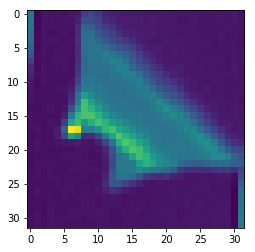

  0%|          | 1/4663 [00:00<24:26,  3.18it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


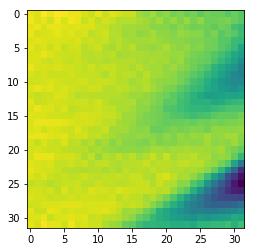

  0%|          | 2/4663 [00:00<21:05,  3.68it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


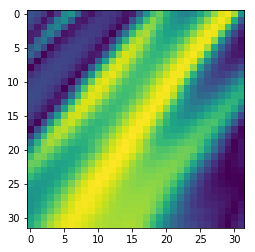

  0%|          | 3/4663 [00:00<18:33,  4.19it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


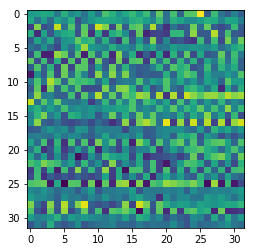

  0%|          | 4/4663 [00:00<16:41,  4.65it/s]

------------------------------------------
False positive
Label =  No triangle  =  0
prediction =  1


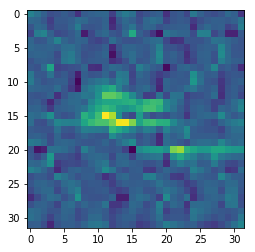

100%|██████████| 4663/4663 [04:16<00:00, 18.19it/s]  


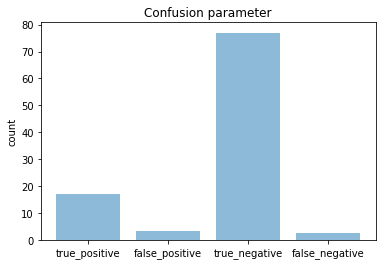

adding a dense layer
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_12_input (InputLayer)    [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 32)   320         conv2d_12_input[0][0]            
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_8[0][0]            
_______________________________________________________________________

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


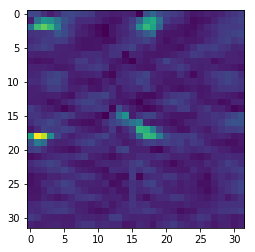

  0%|          | 1/4663 [00:00<30:54,  2.51it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


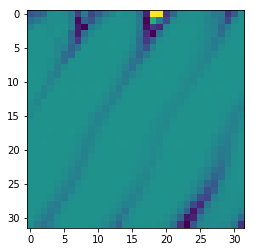

  0%|          | 2/4663 [00:00<25:41,  3.02it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


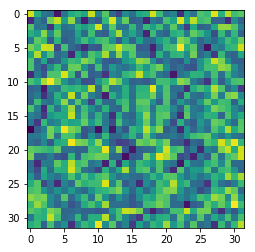

  0%|          | 3/4663 [00:00<22:37,  3.43it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


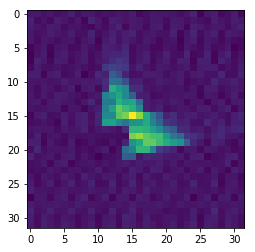

  0%|          | 4/4663 [00:00<19:27,  3.99it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


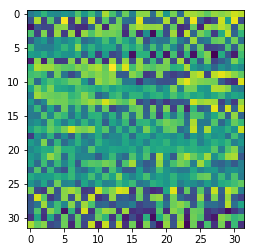

100%|██████████| 4663/4663 [05:05<00:00, 15.28it/s]   


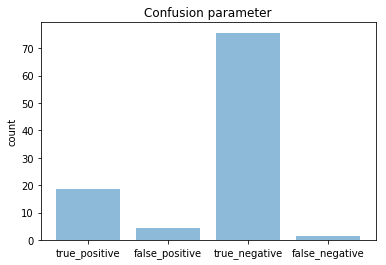

In [10]:
epochs = 10
batch_size = 100
for i in range(2):
    
    
    cnn_model = create_cnn_model()
    statistical_model = create_statistical_model()
    two_phase_model = create_final_model(cnn_model,statistical_model)
    two_phase_model.summary()
    compile_model(two_phase_model)

    z=np.arange(len(images))
    random.shuffle(z)
    print(z[:10])

    images_copy=images.copy()
    images_shuffle=images.copy()
    labels_copy=labels.copy()
    labels_shuffle=labels.copy()

    for i in range(len(images)):
        images_shuffle[i]=images_copy[z[i]]
        labels_shuffle[i]=labels_copy[z[i]]   
    
    two_phase_model, history, percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative= train_model(two_phase_model,images_shuffle,labels_shuffle,epochs,batch_size)
    perc_true_positive_tot.append(percent_true_positive)
    perc_false_positive_tot.append(percent_false_positive)
    perc_true_negative_tot.append(percent_true_negative)
    perc_false_negative_tot.append(percent_false_negative)

adding a dense layer
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_15_input (InputLayer)    [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 32)   320         conv2d_15_input[0][0]            
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_10[0][0]           
_______________________________________________________________________

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


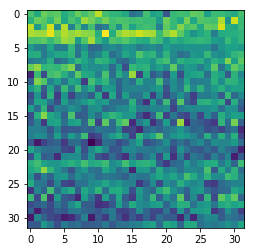

  0%|          | 1/4663 [00:00<29:56,  2.60it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


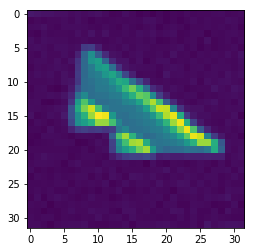

  0%|          | 2/4663 [00:00<25:12,  3.08it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


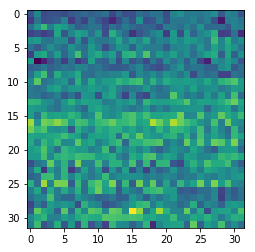

  0%|          | 3/4663 [00:00<21:23,  3.63it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


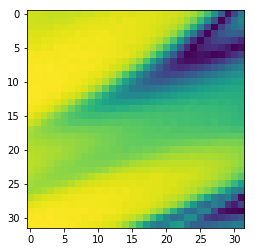

  0%|          | 4/4663 [00:00<19:00,  4.09it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


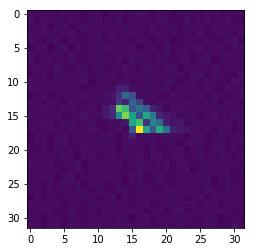

100%|██████████| 4663/4663 [11:29<00:00,  6.76it/s]  


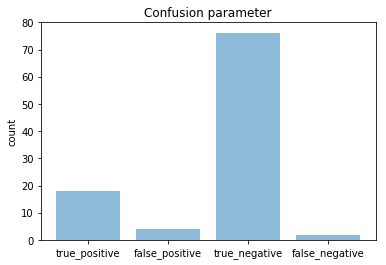

adding a dense layer
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_18_input (InputLayer)    [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 32)   320         conv2d_18_input[0][0]            
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_12[0][0]           
_______________________________________________________________________

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


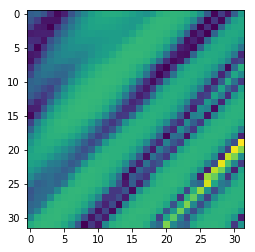

  0%|          | 1/4663 [00:00<46:59,  1.65it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


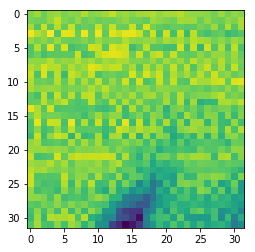

  0%|          | 2/4663 [00:00<38:40,  2.01it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


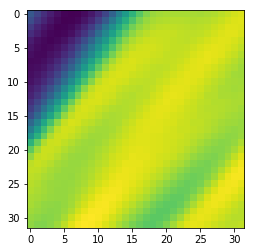

  0%|          | 3/4663 [00:01<32:21,  2.40it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


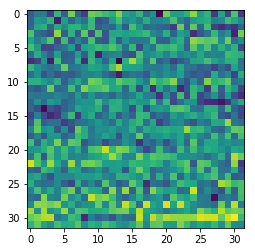

  0%|          | 4/4663 [00:01<28:06,  2.76it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


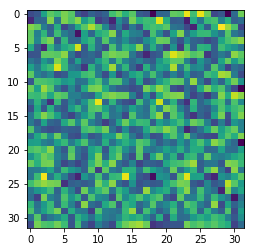

100%|██████████| 4663/4663 [03:28<00:00, 22.41it/s]


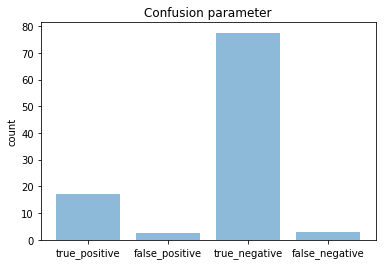

In [11]:
epochs = 10
batch_size = 100
for i in range(2):
    
    
    cnn_model = create_cnn_model()
    statistical_model = create_statistical_model()
    two_phase_model = create_final_model(cnn_model,statistical_model)
    two_phase_model.summary()
    compile_model(two_phase_model)

    z=np.arange(len(images))
    random.shuffle(z)
    print(z[:10])

    images_copy=images.copy()
    images_shuffle=images.copy()
    labels_copy=labels.copy()
    labels_shuffle=labels.copy()

    for i in range(len(images)):
        images_shuffle[i]=images_copy[z[i]]
        labels_shuffle[i]=labels_copy[z[i]]   
    
    two_phase_model, history, percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative= train_model(two_phase_model,images_shuffle,labels_shuffle,epochs,batch_size)
    perc_true_positive_tot.append(percent_true_positive)
    perc_false_positive_tot.append(percent_false_positive)
    perc_true_negative_tot.append(percent_true_negative)
    perc_false_negative_tot.append(percent_false_negative)

adding a dense layer
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_21_input (InputLayer)    [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 32)   320         conv2d_21_input[0][0]            
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_14[0][0]           
_______________________________________________________________________

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


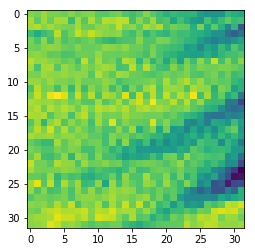

  0%|          | 1/4663 [00:00<31:05,  2.50it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


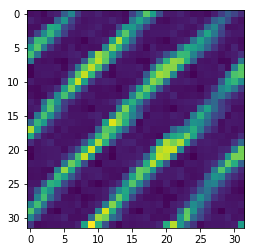

  0%|          | 2/4663 [00:00<25:58,  2.99it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


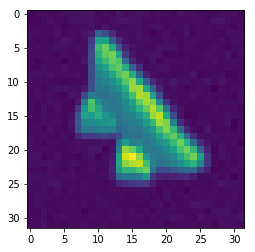

  0%|          | 3/4663 [00:00<21:56,  3.54it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


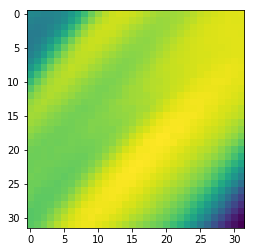

  0%|          | 4/4663 [00:00<19:18,  4.02it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


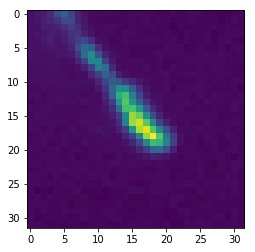

100%|██████████| 4663/4663 [12:40<00:00,  6.13it/s]    


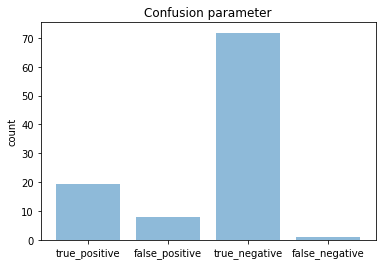

adding a dense layer
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_24_input (InputLayer)    [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 32, 32, 32)   320         conv2d_24_input[0][0]            
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_16[0][0]           
_______________________________________________________________________

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


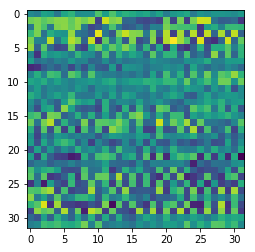

  0%|          | 1/4663 [00:00<42:16,  1.84it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


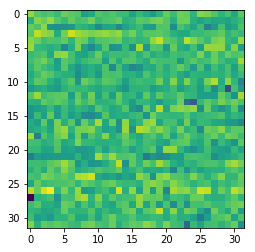

  0%|          | 2/4663 [00:00<33:47,  2.30it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


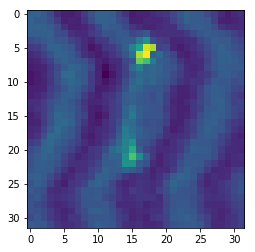

  0%|          | 3/4663 [00:00<28:44,  2.70it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


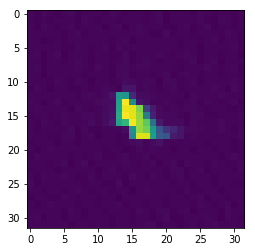

  0%|          | 4/4663 [00:01<24:35,  3.16it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


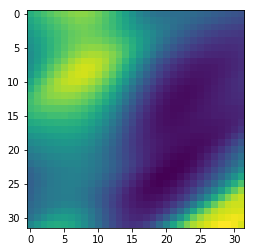

100%|██████████| 4663/4663 [22:54<00:00,  3.39it/s]    


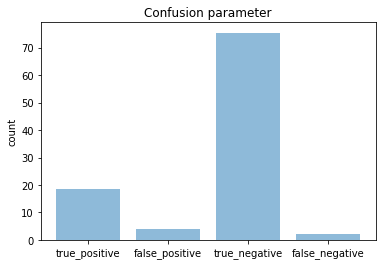

In [12]:
epochs = 10
batch_size = 100
for i in range(2):
    
    
    cnn_model = create_cnn_model()
    statistical_model = create_statistical_model()
    two_phase_model = create_final_model(cnn_model,statistical_model)
    two_phase_model.summary()
    compile_model(two_phase_model)

    z=np.arange(len(images))
    random.shuffle(z)
    print(z[:10])

    images_copy=images.copy()
    images_shuffle=images.copy()
    labels_copy=labels.copy()
    labels_shuffle=labels.copy()

    for i in range(len(images)):
        images_shuffle[i]=images_copy[z[i]]
        labels_shuffle[i]=labels_copy[z[i]]   
    
    two_phase_model, history, percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative= train_model(two_phase_model,images_shuffle,labels_shuffle,epochs,batch_size)
    perc_true_positive_tot.append(percent_true_positive)
    perc_false_positive_tot.append(percent_false_positive)
    perc_true_negative_tot.append(percent_true_negative)
    perc_false_negative_tot.append(percent_false_negative)

adding a dense layer
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_27_input (InputLayer)    [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 32)   320         conv2d_27_input[0][0]            
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_18[0][0]           
_______________________________________________________________________

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


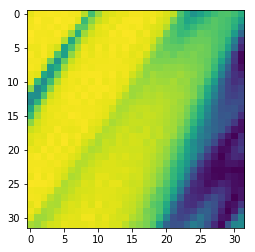

  0%|          | 1/4663 [00:00<48:16,  1.61it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


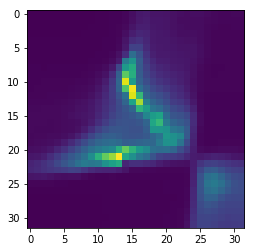

  0%|          | 2/4663 [00:00<38:25,  2.02it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


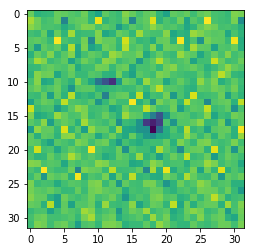

  0%|          | 3/4663 [00:01<31:52,  2.44it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


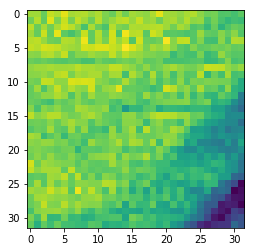

  0%|          | 4/4663 [00:01<27:19,  2.84it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


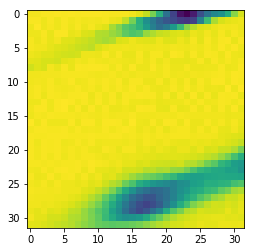

100%|██████████| 4663/4663 [03:36<00:00, 21.56it/s]


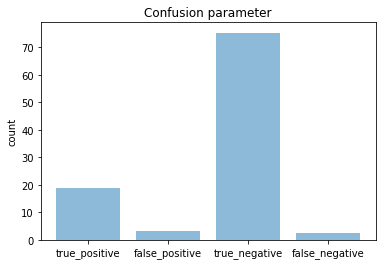

adding a dense layer
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_30_input (InputLayer)    [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 32, 32, 32)   320         conv2d_30_input[0][0]            
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_20[0][0]           
______________________________________________________________________

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


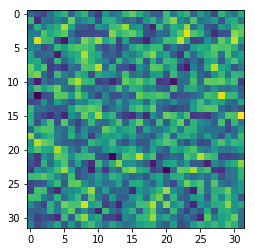

  0%|          | 1/4663 [00:00<30:26,  2.55it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


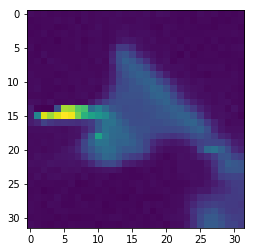

  0%|          | 2/4663 [00:00<25:24,  3.06it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


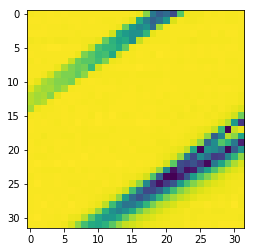

  0%|          | 3/4663 [00:00<21:42,  3.58it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


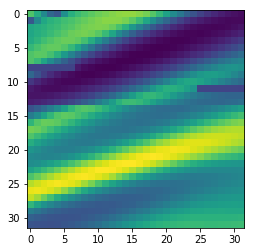

  0%|          | 4/4663 [00:00<19:27,  3.99it/s]

------------------------------------------
False positive
Label =  No triangle  =  0
prediction =  1


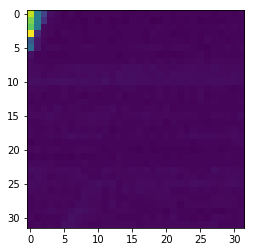

100%|██████████| 4663/4663 [34:09<00:00,  2.27it/s]     


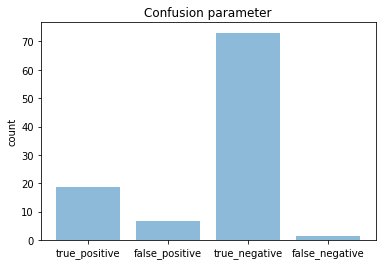

In [13]:
epochs = 10
batch_size = 100
for i in range(2):
    
    
    cnn_model = create_cnn_model()
    statistical_model = create_statistical_model()
    two_phase_model = create_final_model(cnn_model,statistical_model)
    two_phase_model.summary()
    compile_model(two_phase_model)

    z=np.arange(len(images))
    random.shuffle(z)
    print(z[:10])

    images_copy=images.copy()
    images_shuffle=images.copy()
    labels_copy=labels.copy()
    labels_shuffle=labels.copy()

    for i in range(len(images)):
        images_shuffle[i]=images_copy[z[i]]
        labels_shuffle[i]=labels_copy[z[i]]   
    
    two_phase_model, history, percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative= train_model(two_phase_model,images_shuffle,labels_shuffle,epochs,batch_size)
    perc_true_positive_tot.append(percent_true_positive)
    perc_false_positive_tot.append(percent_false_positive)
    perc_true_negative_tot.append(percent_true_negative)
    perc_false_negative_tot.append(percent_false_negative)

In [14]:
import csv
total_dict = {'1': perc_false_positive_tot, 
         '2': perc_false_negative_tot, 
         '3': perc_true_positive_tot, 
         '4': perc_true_negative_tot
        }
 
keys = sorted(total_dict.keys())
with open("CNN_Two_Stage_Shuffle_Clean_Data_Recompile_Model.csv", "w") as outfile:
    writer = csv.writer(outfile, delimiter = "\t")
    writer.writerow(keys)
    writer.writerows(zip(*[total_dict[key] for key in keys]))

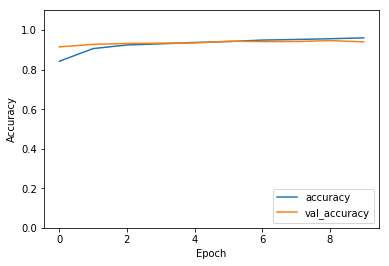

In [15]:
evaluate_model(two_phase_model,history)

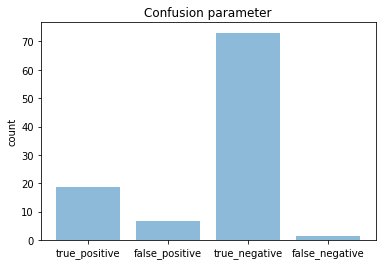

In [16]:
plot_confusion(percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative)

In [17]:
print('Percent true positive  ',percent_true_positive,'%')
print('Percent false positive  ',percent_false_positive,'%')
print('Percent true negative  ',percent_true_negative,'%')
print('Percent false negative  ',percent_false_negative,'%')
print('Percent Total True   ',(percent_true_positive + percent_true_negative),'%')


Percent true positive   18.76474372721424 %
Percent false positive   6.626635213381943 %
Percent true negative   73.06455071842161 %
Percent false negative   1.5440703409822003 %
Percent Total True    91.82929444563585 %
